In [1]:
import os
import sys
import numpy as np
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
import julian
from tletools import TLE
from scipy.signal import find_peaks
from numpy import pi

In [2]:
%load_ext julia.magic
%julia import Pkg
%julia Pkg.add("SatelliteToolbox")
%julia using SatelliteToolbox

Initializing Julia interpreter. This may take some time...


    Updating registry at `C:\Users\Soumyajit Dey\.julia\registries\General`
    Updating git-repo `https://github.com/JuliaRegistries/General.git`
   Resolving package versions...
  No Changes to `C:\Users\Soumyajit Dey\.julia\environments\v1.6\Project.toml`
  No Changes to `C:\Users\Soumyajit Dey\.julia\environments\v1.6\Manifest.toml`


In [3]:
FilePath = 'C:\\Users\\Soumyajit Dey\\OneDrive\\Documents\\SGP4\\TLES\\'
os.chdir(FilePath)

FileName = 'grace11.txt'
f = open(FileName,'r')
Data = f.readlines()
f.close()
epochs = []
n_o = []
dn_o2 = []
C2 = []
Bstar = []

#import TLE data
for i in range(int(len(Data)/2)):
    tle_str = 'GRACE \n' + Data[2*i] + Data[2*i + 1]
    tle = tle_str.strip().splitlines()
    tle = TLE.from_lines(*tle)
    epochs.append(dt.datetime(tle.epoch_year,1,1,0,0,0) + dt.timedelta(days = tle.epoch_day - 1))
    n_o.append(tle.n)
    dn_o2.append(2*tle.dn_o2)
    
epochs = pd.DatetimeIndex(epochs)
idx = np.where((epochs >= dt.datetime(2011,1,1,0,0,0)) & (epochs <= dt.datetime(2011,12,31,0,0,0)))[0]

for i in range(len(idx)):
    idx0 = 2*idx[i]
    idx1 = 2*idx[i] + 1
    tle_l1 = Data[idx0]
    tle_l2 = Data[idx1]
    %julia tle_str = "GRACE \n" * $tle_l1 * $tle_l2
    %julia tle_scd = read_tle_from_string(tle_str)
    %julia orbp = init_orbit_propagator(Val(:sgp4),tle_scd[1])
    %julia bstar = orbp.sgp4d.bstar
    %julia c1 = orbp.sgp4d.C1
    %julia c2 = c1/bstar
    bstar = %julia bstar
    c2 = %julia c2
    C2.append(c2)
    Bstar.append(bstar)
    if i%50 == 0:
        print(i)
    

0
50
100
150
200
250
300
350
400
450
500
550


In [15]:
Bstar_est = []
Bstar_est1 = []
dno_mod = []
delta_n = []
delta_t = []
time_array = epochs[idx];

##convert n_o from rev/day --> rad/min
#         n_o2 from rev/day^2 --> rad/min^2
n_mod = [n_o[i]*2*pi/1440 for i in range(len(idx))]
nt_mod = [dn_o2[i]*2*pi/(1440*1440) for i in range(len(idx))]

for i in range(len(idx)-1):
    delta_n.append(n_mod[i+1] - n_mod[i])
    delta_t.append((time_array[i+1] - time_array[i])/dt.timedelta(minutes = 1))
    if delta_t[i] == 0:
        dno_mod.append(nt_mod[i+1])
    else:
        dno = delta_n[i]/delta_t[i]
        dno_mod.append(dno)
            
dno_mod.insert(0,nt_mod[0])
for i in range(len(idx)):
    bstar_est = nt_mod[i]/n_mod[i]/C2[i]/1.5
    Bstar_est.append(bstar_est)
    bstar_est1 = dno_mod[i]/n_mod[i]/C2[i]/1.5
    Bstar_est1.append(bstar_est1)

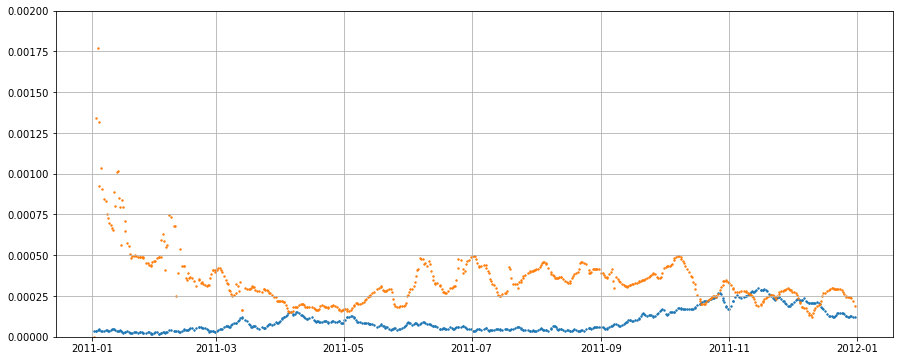

In [32]:
plt.figure(figsize = [15,6])
plt.scatter(time_array,Bstar,s=2)
plt.scatter(time_array,Bstar_est,s=2)

plt.yscale('linear')
plt.ylim([0 ,0.002])
plt.grid(which='both',axis = 'both')
fname = 'Bstar_estimation_grace.jpg'
plt.savefig(fname)

ValueError: x and y must be the same size

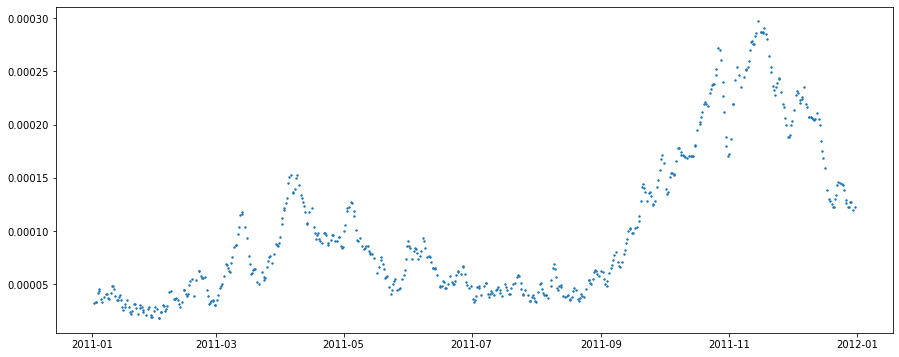

In [8]:
plt.figure(figsize = [15,6])
plt.scatter(time_array,Bstar,s= 2)
plt.scatter(time_array,Bstar_est,s=2)
plt.grid()
fname = 'Bstar_estimation_goce.jpg'
plt.savefig(fname)

In [ ]:
os.getcwd()

'1 34602U 09013A   11219.55290652 -.00002866  19089-5 -31340-5 0  9998\n2 34602 096.6202 238.3083 0006468 046.4566 313.7237 16.05965403140004\n'